# **Market Size Analysis on Electric Vehicles Industries**

In [ ]:
# Data Cleaning and Preparation:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
filename = '/content/Electric_Vehicle_Population_Data.xlsx'
df = pd.read_excel(filename)

print("--- Data Before Cleaning ---")
print(df[['Base MSRP', 'Electric Range', 'Vehicle Location']].head(3))

# ---------------------------------------------------------
# Step 1: Handle Missing or Inconsistent Data
# ---------------------------------------------------------

# A. Base MSRP
# The dataset uses 0 to represent unknown/missing prices.
# We replace 0 with NaN so functions like .mean() don't treat them as free cars.
df['Base MSRP'] = df['Base MSRP'].replace(0, np.nan)

# B. Electric Range
# 0 indicates "not researched". We replace it with NaN.
df['Electric Range'] = df['Electric Range'].replace(0, np.nan)

# C. Vehicle Location
# Parse "POINT (-122.3 47.6)" into two separate float columns
def extract_coordinates(location_str):
    if pd.isna(location_str):
        return np.nan, np.nan
    try:
        # Remove 'POINT (' and ')' and split by space
        clean_str = location_str.replace('POINT (', '').replace(')', '')
        parts = clean_str.split()
        return float(parts[0]), float(parts[1])
    except:
        return np.nan, np.nan

# Apply the extraction
df['Longitude'], df['Latitude'] = zip(*df['Vehicle Location'].apply(extract_coordinates))

# ---------------------------------------------------------
# Step 2: Standardize Data Formats
# ---------------------------------------------------------

# A. Model Year
# Ensure it is an integer (remove any float decimals if they exist)
# Drop rows where Model Year is unknown (if any)
df = df.dropna(subset=['Model Year'])
df['Model Year'] = df['Model Year'].astype(int)

# B. Legislative District
# Ensure it is numeric
df['Legislative District'] = pd.to_numeric(df['Legislative District'], errors='coerce')

# ---------------------------------------------------------
# Step 3: Summary of Cleaning
# ---------------------------------------------------------

print("\n--- Data Cleaning Summary ---")
print(f"Total Rows: {len(df)}")
print(f"Rows with Missing MSRP (NaN): {df['Base MSRP'].isnull().sum()}")
print(f"Rows with Missing Range (NaN): {df['Electric Range'].isnull().sum()}")

print("\n--- Cleaned Data Sample ---")
print(df[['Make', 'Model', 'Model Year', 'Base MSRP', 'Electric Range', 'Longitude', 'Latitude']].head())

# Optional: Save cleaned data for future steps
# df.to_csv('Cleaned_EV_Data.csv', index=False)

--- Data Before Cleaning ---
   Base MSRP  Electric Range               Vehicle Location
0          0             291   POINT (-122.30839 47.610365)
1          0               0  POINT (-122.179458 47.802589)
2          0             270   POINT (-122.34848 47.632405)

--- Data Cleaning Summary ---
Total Rows: 177866
Rows with Missing MSRP (NaN): 174522
Rows with Missing Range (NaN): 91950

--- Cleaned Data Sample ---
    Make    Model  Model Year  Base MSRP  Electric Range   Longitude  \
0  TESLA  MODEL Y        2020        NaN           291.0 -122.308390   
1  TESLA  MODEL Y        2023        NaN             NaN -122.179458   
2  TESLA  MODEL S        2019        NaN           270.0 -122.348480   
3  TESLA  MODEL S        2016        NaN           210.0 -122.036460   
4  TESLA  MODEL Y        2021        NaN             NaN -122.557170   

    Latitude  
0  47.610365  
1  47.802589  
2  47.632405  
3  47.534065  
4  47.733415  


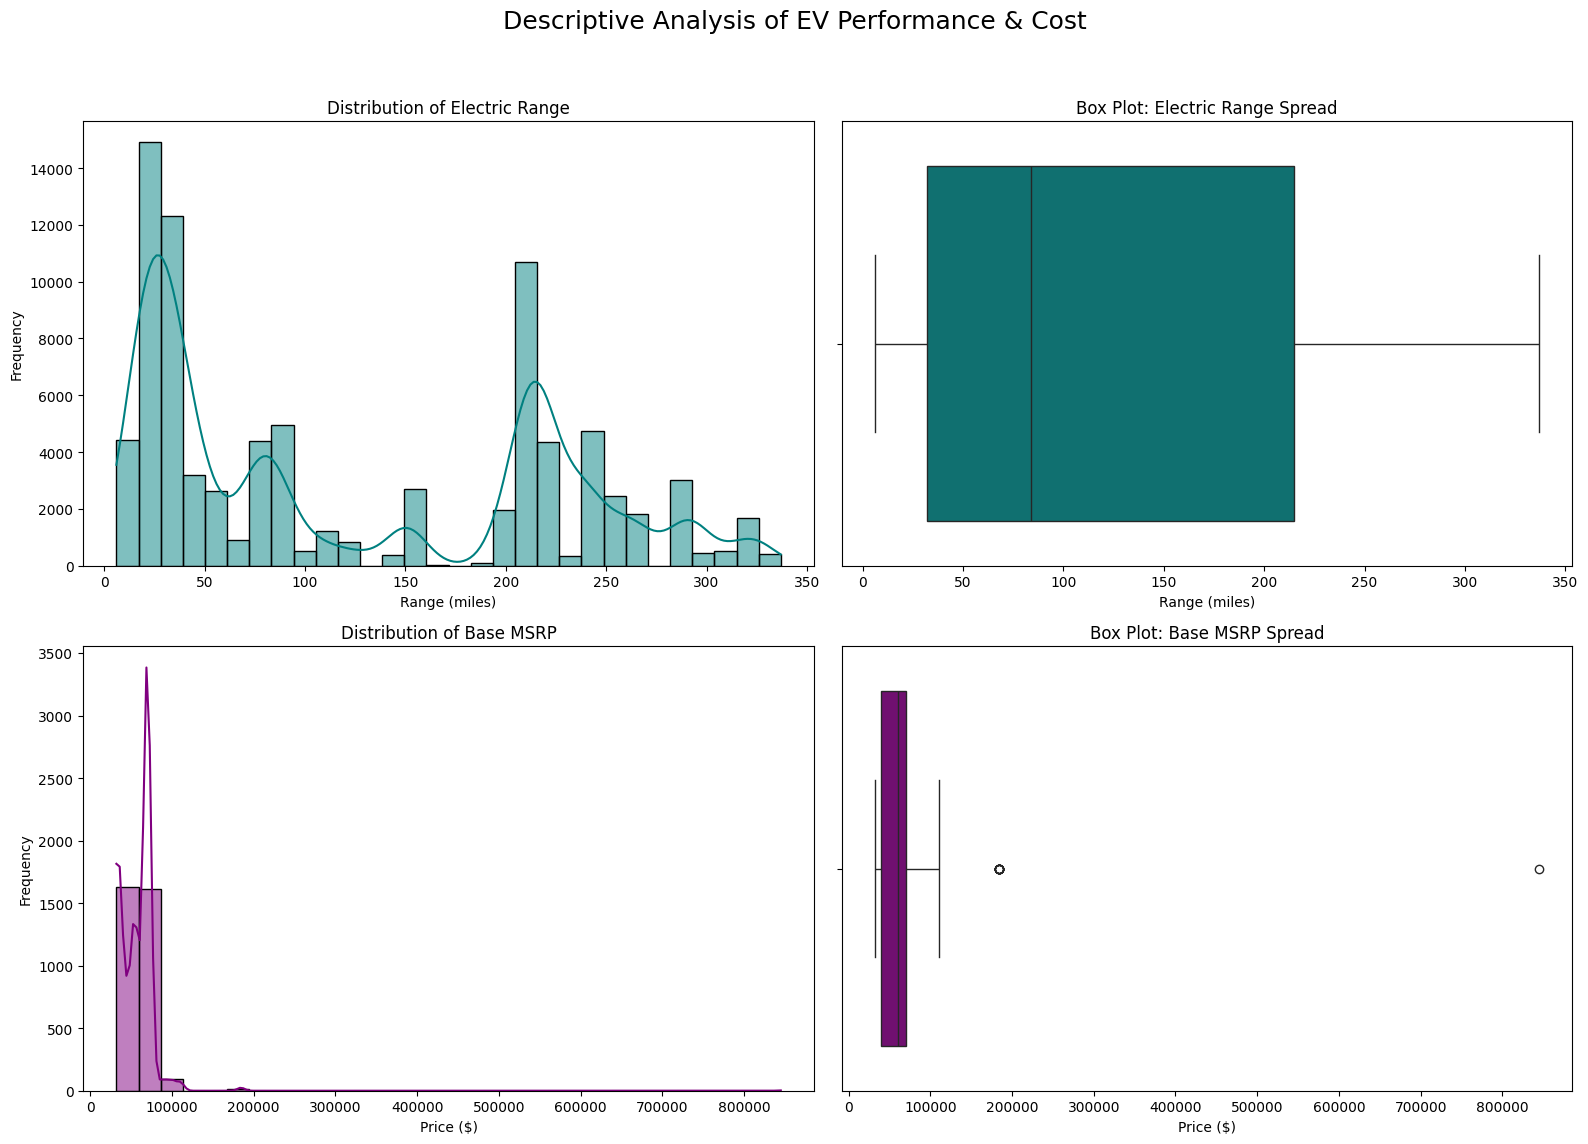

--- Summary Statistics (Excluding 0/Missing Values) ---
        Electric Range (miles)  Base MSRP ($)
mean                    121.82       57078.25
median                   84.00       59900.00
std                      99.22       22795.52
min                       6.00       31950.00
max                     337.00      845000.00


In [ ]:
# Descriptive Analysis:

# Data Preparation (Filter out missing/zero values)
# We create temporary series that drop NaNs and 0s for accurate statistics
valid_range = df[df['Electric Range'] > 0]['Electric Range']
valid_msrp = df[df['Base MSRP'] > 0]['Base MSRP']

# Calculate Summary Statistics
stats_summary = pd.DataFrame({
    'Electric Range (miles)': valid_range.describe()[['mean', '50%', 'std', 'min', 'max']],
    'Base MSRP ($)': valid_msrp.describe()[['mean', '50%', 'std', 'min', 'max']]
})
# Rename '50%' to 'Median' for clarity
stats_summary.rename(index={'50%': 'median'}, inplace=True)

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Descriptive Analysis of EV Performance & Cost', fontsize=18)

# --- Plot 1: Histogram of Electric Range ---
sns.histplot(valid_range, kde=True, ax=axes[0, 0], color='teal', bins=30)
axes[0, 0].set_title('Distribution of Electric Range')
axes[0, 0].set_xlabel('Range (miles)')
axes[0, 0].set_ylabel('Frequency')

# --- Plot 2: Box Plot of Electric Range ---
sns.boxplot(x=valid_range, ax=axes[0, 1], color='teal')
axes[0, 1].set_title('Box Plot: Electric Range Spread')
axes[0, 1].set_xlabel('Range (miles)')

# --- Plot 3: Histogram of Base MSRP ---
sns.histplot(valid_msrp, kde=True, ax=axes[1, 0], color='purple', bins=30)
axes[1, 0].set_title('Distribution of Base MSRP')
axes[1, 0].set_xlabel('Price ($)')
axes[1, 0].set_ylabel('Frequency')
# Format x-axis to show $ signs nicely? (Optional, kept simple for now)

# --- Plot 4: Box Plot of Base MSRP ---
sns.boxplot(x=valid_msrp, ax=axes[1, 1], color='purple')
axes[1, 1].set_title('Box Plot: Base MSRP Spread')
axes[1, 1].set_xlabel('Price ($)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Output Statistics Table
print("--- Summary Statistics (Excluding 0/Missing Values) ---")
print(stats_summary.round(2))

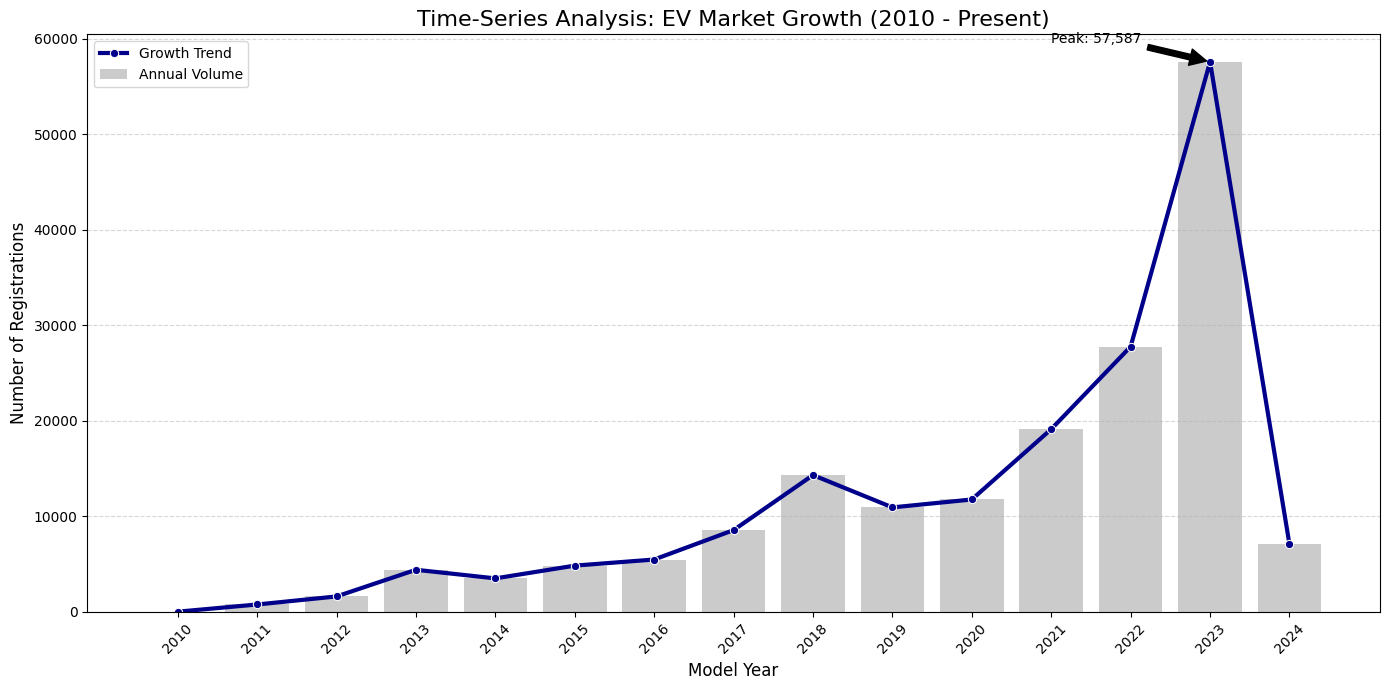

--- Annual Registration Trend ---
    Model Year  Registrations
0         2010             23
1         2011            775
2         2012           1618
3         2013           4409
4         2014           3509
5         2015           4844
6         2016           5483
7         2017           8562
8         2018          14323
9         2019          10940
10        2020          11768
11        2021          19132
12        2022          27776
13        2023          57587
14        2024           7080

Growth Insight: The market grew by a factor of 4.0x from 2018 to 2023.


In [ ]:
# Time-Series Analysis:

# Data Preparation
# Filter for valid Model Years.
# We focus on the "Modern EV Era" (2010 onwards).
# We exclude 2024 if it represents incomplete data (partial year),
# but let's keep it to show the current year-to-date status.
df_trend = df[df['Model Year'] >= 2010]

# Aggregate counts by Model Year
yearly_counts = df_trend['Model Year'].value_counts().sort_index().reset_index()
yearly_counts.columns = ['Model Year', 'Registrations']

# Visualization
plt.figure(figsize=(14, 7))

# Create a combination plot: Bar for volume, Line for trend
# Bar Plot (Volume)
sns.barplot(x='Model Year', y='Registrations', data=yearly_counts,
            color='#A9A9A9', alpha=0.6, label='Annual Volume')

# Line Plot (Trend)
sns.lineplot(x=yearly_counts.index, y='Registrations', data=yearly_counts,
             marker='o', color='#00008B', linewidth=3, label='Growth Trend')

# Annotate the peak value
peak_year_index = yearly_counts['Registrations'].idxmax()
peak_val = yearly_counts['Registrations'].max()
plt.annotate(f'Peak: {peak_val:,}',
             xy=(peak_year_index, peak_val),
             xytext=(peak_year_index-2, peak_val+2000),
             arrowprops=dict(facecolor='black', shrink=0.05))

# Formatting
plt.title('Time-Series Analysis: EV Market Growth (2010 - Present)', fontsize=16)
plt.xlabel('Model Year', fontsize=12)
plt.ylabel('Number of Registrations', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend()

plt.tight_layout()
plt.show()

# Output Trend Data
print("--- Annual Registration Trend ---")
print(yearly_counts)

# Calculate simple growth factor (Last full year vs 5 years ago)
# Assuming 2023 is last full year and 2018 is 5 years prior
try:
    vol_2023 = yearly_counts[yearly_counts['Model Year'] == 2023]['Registrations'].values[0]
    vol_2018 = yearly_counts[yearly_counts['Model Year'] == 2018]['Registrations'].values[0]
    growth_factor = vol_2023 / vol_2018
    print(f"\nGrowth Insight: The market grew by a factor of {growth_factor:.1f}x from 2018 to 2023.")
except IndexError:
    print("\n(Could not calculate specific 2018-2023 growth factor due to missing data years)")

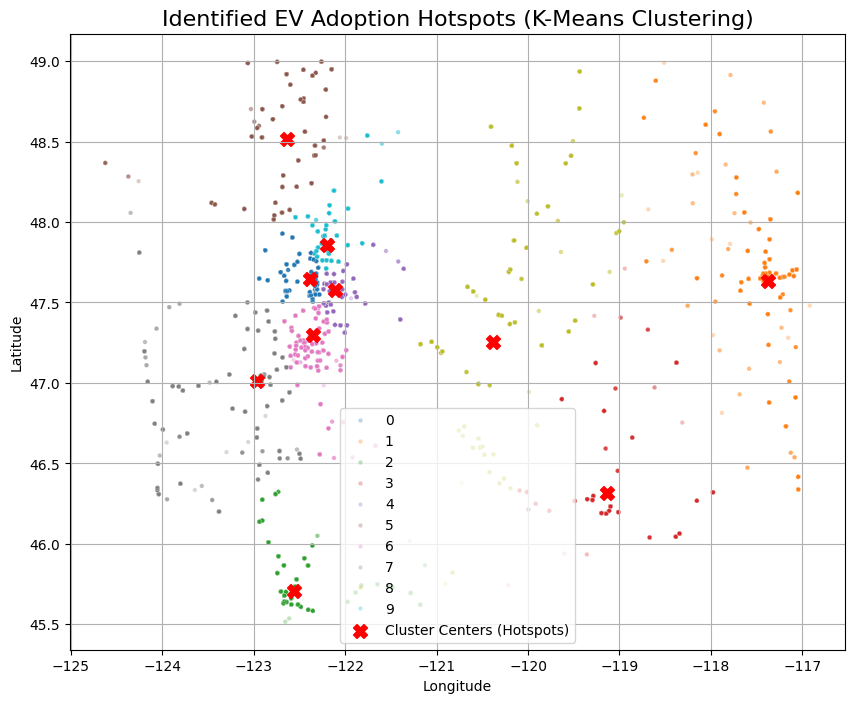

Interactive map saved as 'ev_hotspot_map.html'. Open it to explore the heatmap.

--- Identified Hotspot Centers (Lat, Lon) ---
[[  47.64412617 -122.38196216]
 [  47.63197831 -117.37091172]
 [  45.70871861 -122.55513942]
 [  46.31347881 -119.14077362]
 [  47.57548998 -122.10901818]
 [  48.51609318 -122.63358394]
 [  47.29644745 -122.34797498]
 [  47.01245314 -122.96704861]
 [  47.25506127 -120.38590335]
 [  47.85644598 -122.19902423]]


In [ ]:
# Geographical Analysis:

import pandas as pd
import numpy as np
import folium
from folium.plugins import HeatMap, MarkerCluster
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preparation: Extract Coordinates
def extract_coordinates(location_str):
    if pd.isna(location_str):
        return None, None
    try:
        # Format is typically "POINT (Longitude Latitude)"
        clean_str = location_str.replace('POINT (', '').replace(')', '')
        parts = clean_str.split()
        return float(parts[1]), float(parts[0]) # Return Lat, Lon
    except:
        return None, None

# Apply extraction
df['Latitude'], df['Longitude'] = zip(*df['Vehicle Location'].apply(extract_coordinates))

# Filter for valid coordinates (Focus on WA state area to avoid global outliers)
# WA Lat: ~45.5 to 49, Lon: ~-125 to -116
df_geo = df.dropna(subset=['Latitude', 'Longitude'])
df_geo = df_geo[(df_geo['Latitude'] > 45) & (df_geo['Latitude'] < 50) &
                (df_geo['Longitude'] > -126) & (df_geo['Longitude'] < -116)]

# Clustering Analysis (K-Means)
# We look for 10 major "hotspots" (clusters) of adoption
kmeans = KMeans(n_clusters=10, random_state=42, n_init=10)
df_geo['Cluster'] = kmeans.fit_predict(df_geo[['Latitude', 'Longitude']])
centroids = kmeans.cluster_centers_

# Visualization 1: Static Scatter Plot of Clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Longitude', y='Latitude', data=df_geo, hue='Cluster', palette='tab10', alpha=0.3, s=10)
plt.scatter(centroids[:, 1], centroids[:, 0], c='red', s=100, marker='X', label='Cluster Centers (Hotspots)')
plt.title('Identified EV Adoption Hotspots (K-Means Clustering)', fontsize=16)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True)
plt.show()

# Visualization 2: Interactive Map with Heatmap & Clusters
# Create base map centered on the average location
map_center = [df_geo['Latitude'].mean(), df_geo['Longitude'].mean()]
m = folium.Map(location=map_center, zoom_start=8)

# Add Heatmap Layer
# We use a sample of data if it's too large, but 50k points is usually fine for Folium
heat_data = [[row['Latitude'], row['Longitude']] for index, row in df_geo.iterrows()]
HeatMap(heat_data, radius=10, blur=15).add_to(m)

# Add Markers for Cluster Centers
for i, centroid in enumerate(centroids):
    folium.Marker(
        location=[centroid[0], centroid[1]],
        popup=f'Hotspot #{i+1}',
        icon=folium.Icon(color='red', icon='info-sign')
    ).add_to(m)

# Save the interactive map
m.save('ev_hotspot_map.html')
print("Interactive map saved as 'ev_hotspot_map.html'. Open it to explore the heatmap.")
print("\n--- Identified Hotspot Centers (Lat, Lon) ---")
print(centroids)

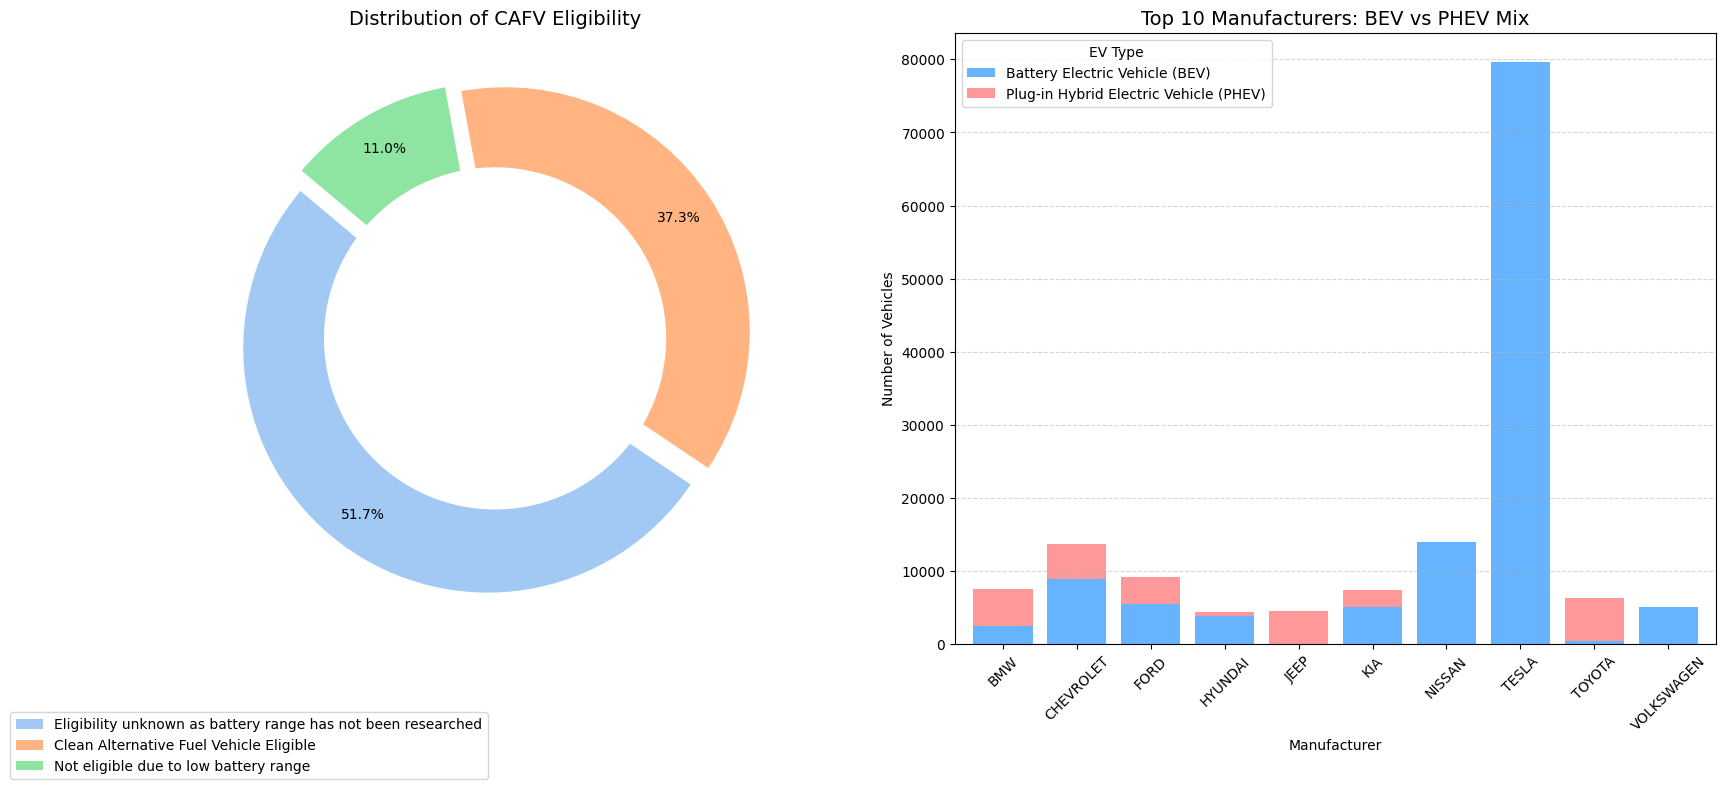

--- CAFV Eligibility Counts ---
Clean Alternative Fuel Vehicle (CAFV) Eligibility
Eligibility unknown as battery range has not been researched    91950
Clean Alternative Fuel Vehicle Eligible                         66331
Not eligible due to low battery range                           19585
Name: count, dtype: int64

--- Top 3 Models for Top 3 Manufacturers ---

Manufacturer: TESLA
Model
MODEL Y    35989
MODEL 3    30092
MODEL S     7735
Name: count, dtype: int64

Manufacturer: NISSAN
Model
LEAF     13366
ARIYA      632
Name: count, dtype: int64

Manufacturer: CHEVROLET
Model
BOLT EV     6821
VOLT        4796
BOLT EUV    1772
Name: count, dtype: int64


In [ ]:
#  Segmentation Analysis:

# --- Part 1: CAFV Eligibility Analysis ---
# Count the values in the eligibility column
cafv_counts = df['Clean Alternative Fuel Vehicle (CAFV) Eligibility'].value_counts()

# --- Part 2: Segmentation by Make and EV Type ---
# Identify top 10 manufacturers by total volume
top_makes = df['Make'].value_counts().nlargest(10).index

# Filter data for these top 10 makes
df_top_makes = df[df['Make'].isin(top_makes)]

# Group by Make and Type to get the split (BEV vs PHEV)
make_type_counts = df_top_makes.groupby(['Make', 'Electric Vehicle Type']).size().unstack(fill_value=0)

# --- Visualization ---
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Plot 1: CAFV Eligibility (Donut Chart)
colors = sns.color_palette('pastel')[0:len(cafv_counts)]
axes[0].pie(cafv_counts, labels=None, autopct='%1.1f%%', startangle=140,
            colors=colors, pctdistance=0.85, explode=[0.05]*len(cafv_counts))
# Add a central circle to make it a donut
centre_circle = plt.Circle((0,0),0.70,fc='white')
axes[0].add_artist(centre_circle)
axes[0].legend(cafv_counts.index, loc="best", bbox_to_anchor=(0.5, -0.1))
axes[0].set_title('Distribution of CAFV Eligibility', fontsize=14)

# Plot 2: Make vs EV Type (Stacked Bar Chart)
make_type_counts.plot(kind='bar', stacked=True, ax=axes[1], color=['#66b3ff', '#ff9999'], width=0.8)
axes[1].set_title('Top 10 Manufacturers: BEV vs PHEV Mix', fontsize=14)
axes[1].set_xlabel('Manufacturer')
axes[1].set_ylabel('Number of Vehicles')
axes[1].legend(title='EV Type')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# --- Part 3: Text Summary (Model Breakdown) ---
print("--- CAFV Eligibility Counts ---")
print(cafv_counts)

print("\n--- Top 3 Models for Top 3 Manufacturers ---")
for make in top_makes[:3]:
    print(f"\nManufacturer: {make}")
    top_models = df[df['Make'] == make]['Model'].value_counts().head(3)
    print(top_models)

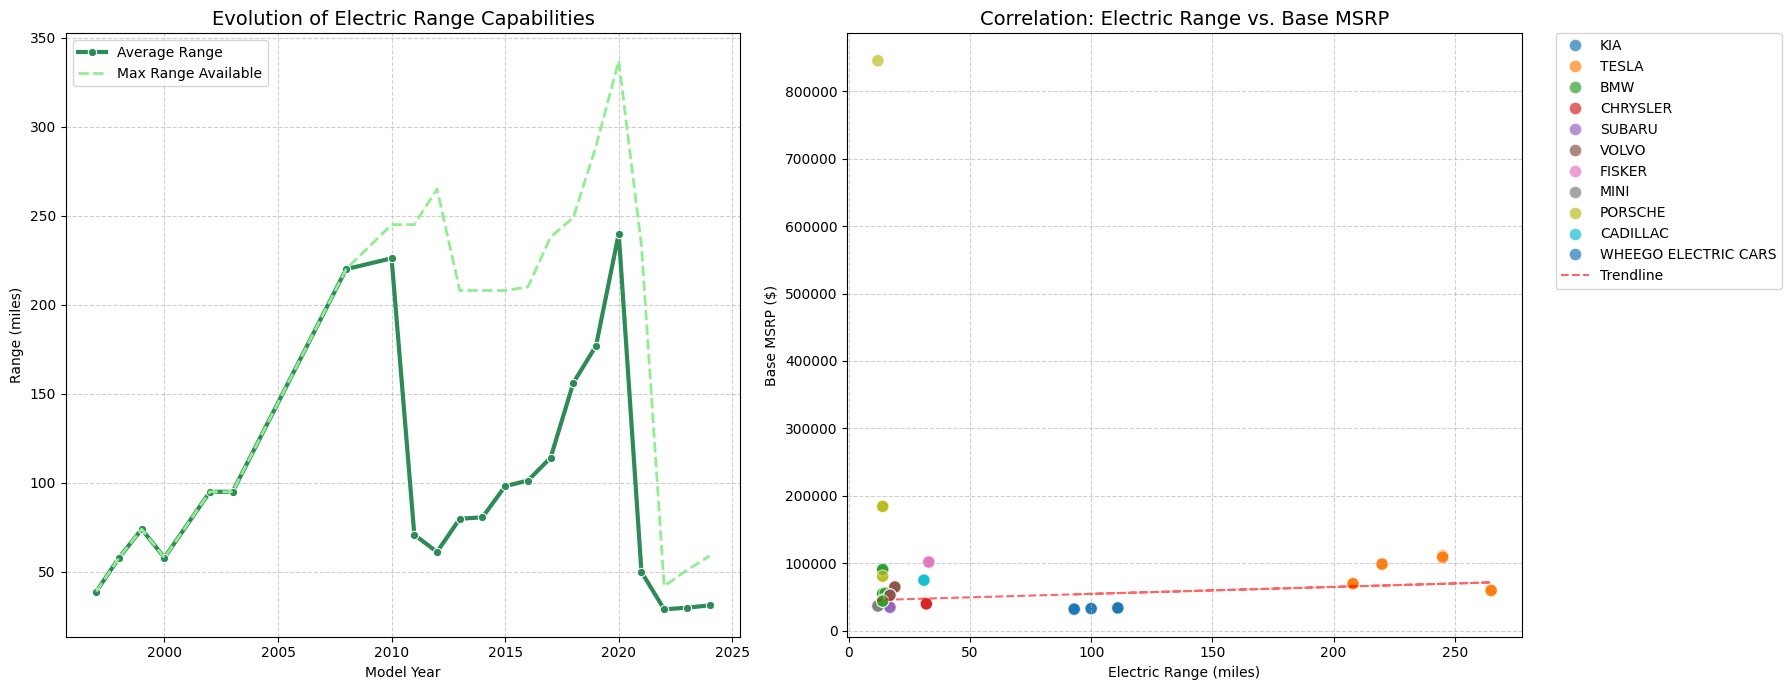

--- Range Evolution Stats (Recent Years) ---
    Model Year        mean    max
17        2020  239.954553  337.0
18        2021   49.957885  233.0
19        2022   29.019630   42.0
20        2023   29.909382   51.0
21        2024   31.228001   59.0

--- Correlation Analysis ---
Pearson Correlation Coefficient (Range vs MSRP): 0.406
Insight: There is a Moderate Positive correlation. Price increases with range, but other luxury factors also drive price.


In [ ]:
# Electric Range Analysis:

# Data Preparation for Evolution Analysis
# Filter out 0 ranges to see the "Technology Capability" trend, not the "Data Completeness" trend
df_valid_range = df[df['Electric Range'] > 0].copy()

# Calculate statistics per year
range_stats = df_valid_range.groupby('Model Year')['Electric Range'].agg(['mean', 'max']).reset_index()

# Data Preparation for Correlation (Range vs MSRP)
# Filter for rows where BOTH Range and MSRP are valid (>0)
df_correlation = df[(df['Electric Range'] > 0) & (df['Base MSRP'] > 0)].copy()

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Plot A: Evolution of Electric Range (Line Plot)
# Mean Range
sns.lineplot(x='Model Year', y='mean', data=range_stats, marker='o',
             color='#2E8B57', linewidth=3, ax=axes[0], label='Average Range')
# Max Range (to show state-of-the-art)
sns.lineplot(x='Model Year', y='max', data=range_stats, linestyle='--',
             color='#90EE90', linewidth=2, ax=axes[0], label='Max Range Available')

axes[0].set_title('Evolution of Electric Range Capabilities', fontsize=14)
axes[0].set_xlabel('Model Year')
axes[0].set_ylabel('Range (miles)')
axes[0].grid(True, linestyle='--', alpha=0.6)
axes[0].legend()

# Plot B: Range vs Base MSRP (Scatter Plot)
sns.scatterplot(x='Electric Range', y='Base MSRP', data=df_correlation,
                hue='Make', palette='tab10', alpha=0.7, s=80, ax=axes[1])

# Add a trendline for the scatter plot
z = np.polyfit(df_correlation['Electric Range'], df_correlation['Base MSRP'], 1)
p = np.poly1d(z)
axes[1].plot(df_correlation['Electric Range'], p(df_correlation['Electric Range']), "r--", alpha=0.6, label='Trendline')

axes[1].set_title('Correlation: Electric Range vs. Base MSRP', fontsize=14)
axes[1].set_xlabel('Electric Range (miles)')
axes[1].set_ylabel('Base MSRP ($)')
axes[1].grid(True, linestyle='--', alpha=0.6)
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout()
plt.show()

# Statistical Insights
correlation = df_correlation['Electric Range'].corr(df_correlation['Base MSRP'])

print("--- Range Evolution Stats (Recent Years) ---")
print(range_stats.tail(5))

print("\n--- Correlation Analysis ---")
print(f"Pearson Correlation Coefficient (Range vs MSRP): {correlation:.3f}")

if correlation > 0.5:
    print("Insight: There is a Strong Positive correlation. You generally pay more for more range.")
elif correlation > 0.3:
    print("Insight: There is a Moderate Positive correlation. Price increases with range, but other luxury factors also drive price.")
else:
    print("Insight: Weak correlation. Range is not the primary driver of the vehicle's price.")

--- Model Validation Results (Train: 2010-2020, Test: 2021-2023) ---
Mean Absolute Error (MAE): 43371 vehicles
R² Score on Test Data: -6.51 (Close to 1.0 is best)
Actual 2023 Volume: 57587
Predicted 2023 Volume: 115206


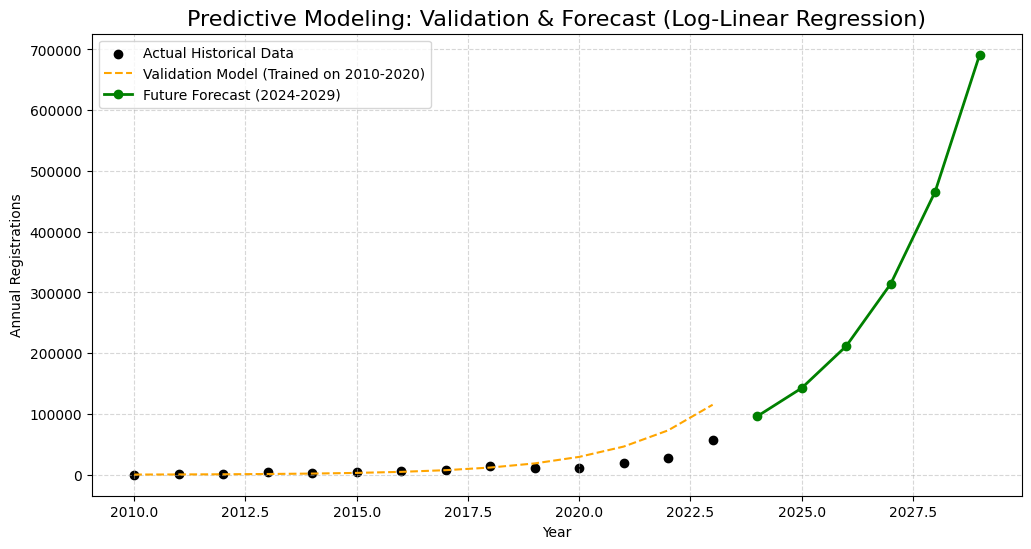


--- Final Forecast (2024-2029) ---
   Year  Predicted Registrations
0  2024                    96075
1  2025                   142570
2  2026                   211566
3  2027                   313952
4  2028                   465886
5  2029                   691348


In [ ]:
# Forecasting:

import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

# Data Preparation
# Group by Year to get annual volume
df_trend = df[(df['Model Year'] >= 2010) & (df['Model Year'] < 2024)]
annual_volume = df_trend['Model Year'].value_counts().sort_index().reset_index()
annual_volume.columns = ['Year', 'Count']

# Prepare X and y
X = annual_volume['Year'].values.reshape(-1, 1)
y = annual_volume['Count'].values

# --- PHASE 1: MODEL VALIDATION (Train/Test Split) ---
# Split data: Train on 2010-2020, Test on 2021-2023
split_index = len(annual_volume[annual_volume['Year'] <= 2020])
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Train Model (Log-Linear Regression)
# We fit log(y) to handle the exponential growth curve
model = LinearRegression()
model.fit(X_train, np.log(y_train))

# Predict on Test Set
y_pred_log = model.predict(X_test)
y_pred = np.exp(y_pred_log) # Convert back from log scale

# Calculate Accuracy Metrics
mae = mean_absolute_error(y_test, y_pred)
accuracy_score = r2_score(y_test, y_pred)

print("--- Model Validation Results (Train: 2010-2020, Test: 2021-2023) ---")
print(f"Mean Absolute Error (MAE): {mae:.0f} vehicles")
print(f"R² Score on Test Data: {accuracy_score:.2f} (Close to 1.0 is best)")
print("Actual 2023 Volume:", y_test[-1])
print("Predicted 2023 Volume:", int(y_pred[-1]))

# --- PHASE 2: FUTURE FORECASTING ---
# Retrain model on ALL data (2010-2023) for best future prediction
final_model = LinearRegression()
final_model.fit(X, np.log(y))

# Create future years (2024-2029)
future_years = np.arange(2024, 2030).reshape(-1, 1)
future_log_pred = final_model.predict(future_years)
future_pred = np.exp(future_log_pred)

# --- VISUALIZATION ---
plt.figure(figsize=(12, 6))

# 1. Historical Data
plt.scatter(X, y, color='black', label='Actual Historical Data')

# Validation Fit (The model trained only on 2010-2020)
# We plot what this model thought 2010-2023 would look like
validation_trend = np.exp(model.predict(X))
plt.plot(annual_volume['Year'], validation_trend, color='orange', linestyle='--', label='Validation Model (Trained on 2010-2020)')

# Final Forecast (2024-2029)
plt.plot(future_years, future_pred, color='green', linewidth=2, marker='o', label='Future Forecast (2024-2029)')

plt.title('Predictive Modeling: Validation & Forecast (Log-Linear Regression)', fontsize=16)
plt.xlabel('Year')
plt.ylabel('Annual Registrations')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Output Forecast Table
forecast_df = pd.DataFrame({'Year': future_years.flatten(), 'Predicted Registrations': future_pred.astype(int)})
print("\n--- Final Forecast (2024-2029) ---")
print(forecast_df)

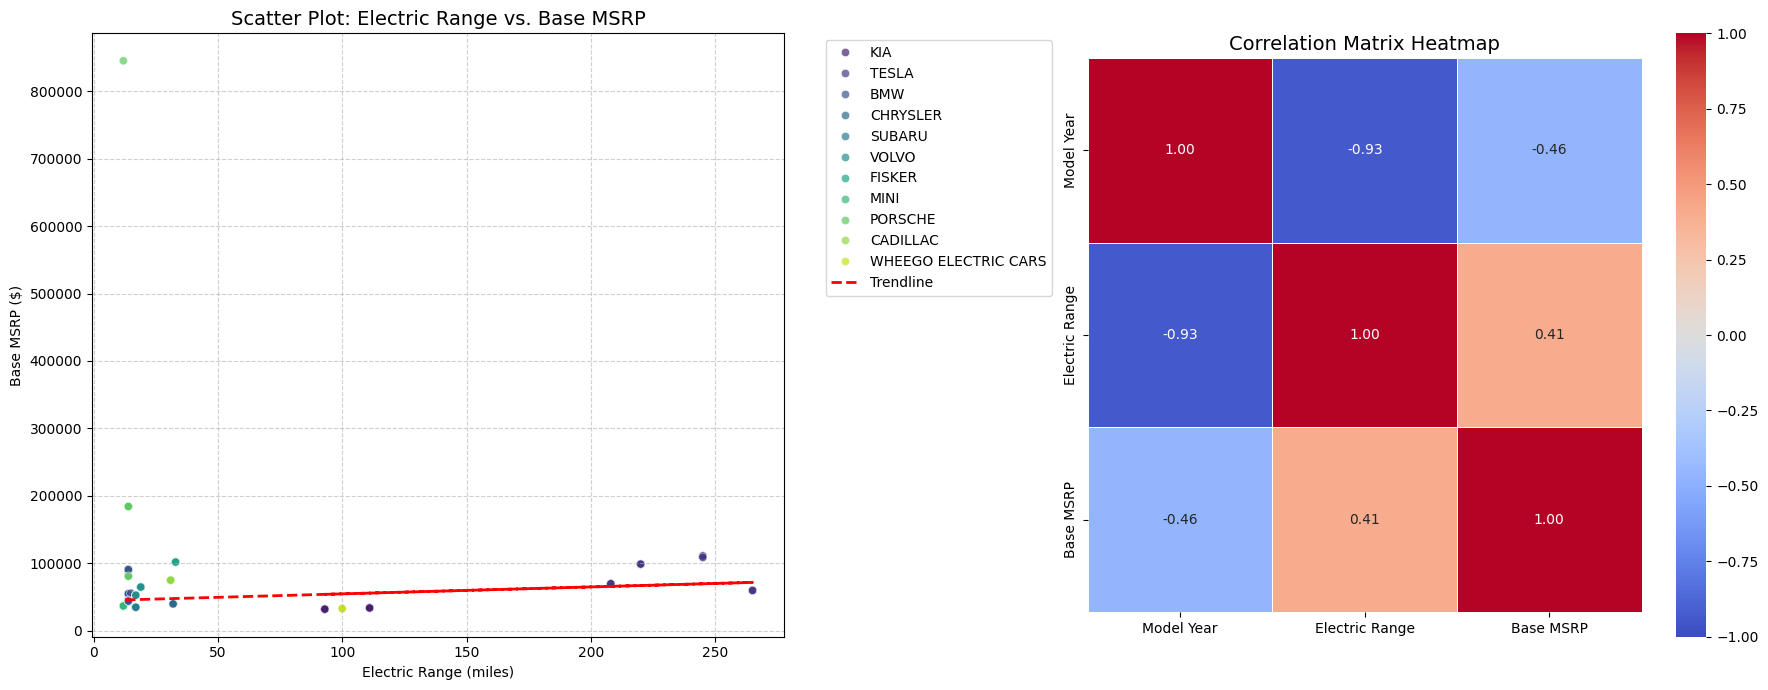

--- Correlation Matrix ---
                Model Year  Electric Range  Base MSRP
Model Year        1.000000       -0.932692  -0.463534
Electric Range   -0.932692        1.000000   0.406043
Base MSRP        -0.463534        0.406043   1.000000

--- Key Insights ---
1. Correlation between Price and Range: 0.41
   -> Moderate positive relationship. While range impacts price, brand and luxury features also play a major role.

2. Correlation between Model Year and Range: -0.93
   -> Negative/Neutral trend. (Note: This might be skewed if recent PHEVs with low range are included while new BEVs have missing data).


In [ ]:
# Correlation and Trend Analysis:

# Data Preparation
# We need to filter for rows where we have VALID data for the variables we want to correlate.
# In this dataset, 0 often means "Unknown" for MSRP and Range.
# We create a subset of data where Range and MSRP are > 0.
df_valid = df[(df['Electric Range'] > 0) & (df['Base MSRP'] > 0)].copy()

# We also want to see trends over time, so we include 'Model Year'.
# We can correlate 'Model Year', 'Electric Range', and 'Base MSRP'.
correlation_cols = ['Model Year', 'Electric Range', 'Base MSRP']
df_corr = df_valid[correlation_cols]

# Visualization

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# --- Plot 1: Scatter Plot (Range vs. MSRP) ---
# This visualizes the direct relationship between cost and performance.
sns.scatterplot(x='Electric Range', y='Base MSRP', data=df_valid,
                hue='Make', palette='viridis', alpha=0.7, ax=axes[0])

# Add a trendline to the scatter plot
z = np.polyfit(df_valid['Electric Range'], df_valid['Base MSRP'], 1)
p = np.poly1d(z)
axes[0].plot(df_valid['Electric Range'], p(df_valid['Electric Range']), "r--", linewidth=2, label='Trendline')

axes[0].set_title('Scatter Plot: Electric Range vs. Base MSRP', fontsize=14)
axes[0].set_xlabel('Electric Range (miles)')
axes[0].set_ylabel('Base MSRP ($)')
axes[0].grid(True, linestyle='--', alpha=0.6)
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left') # Move legend outside if crowded

# --- Plot 2: Correlation Heatmap ---
# Calculate the correlation matrix
corr_matrix = df_corr.corr()

# Create the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1,
            square=True, linewidths=.5, ax=axes[1], fmt=".2f")
axes[1].set_title('Correlation Matrix Heatmap', fontsize=14)

plt.tight_layout()
plt.show()

# Statistical Insights (Text Output)
print("--- Correlation Matrix ---")
print(corr_matrix)

# Interpretation Logic
r_range_price = corr_matrix.loc['Electric Range', 'Base MSRP']
r_year_range = corr_matrix.loc['Model Year', 'Electric Range']

print("\n--- Key Insights ---")
print(f"1. Correlation between Price and Range: {r_range_price:.2f}")
if r_range_price > 0.5:
    print("   -> Strong positive relationship. Higher range generally indicates a significantly higher price.")
elif r_range_price > 0.3:
    print("   -> Moderate positive relationship. While range impacts price, brand and luxury features also play a major role.")
else:
    print("   -> Weak relationship. Price is likely driven by factors other than just range (e.g., brand prestige).")

print(f"\n2. Correlation between Model Year and Range: {r_year_range:.2f}")
if r_year_range > 0:
    print("   -> Positive trend. Newer cars tend to have better range (Technology is improving).")
else:
    print("   -> Negative/Neutral trend. (Note: This might be skewed if recent PHEVs with low range are included while new BEVs have missing data).")